In [1]:
from common import *
from process_ntuples import *
from process_df import *
from plotting import *
from cuts import apply_cuts, apply_pt_cut
import matplotlib.pyplot as plt
import pickle

import tensorflow as tf
from tensorflow.keras import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras import layers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

from tensorflow.keras.callbacks import EarlyStopping

#weights and biases imports
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint, WandbCallback

Welcome to JupyROOT 6.28/00


2023-04-20 17:09:51.981226: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-20 17:09:53.958298: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


$D^{+}$ : 411

$\Lambda_C^{+}$ : 4122

Apply Cuts Fiducial Region cuts ($𝐷^{+}$ $𝑝_T$ > 8 GeV, |𝜂| < 2.2). ***See cuts.py on how the cuts are applied***

In [2]:
print(tf.config.list_physical_devices('GPU'))
# Check if tensorflow is using GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[]
Num GPUs Available:  0


2023-04-16 21:17:16.368459: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [2]:
dir_path = "/global/cfs/cdirs/atlas/gottino/Charm/Analysis/run_batch_gup/ntuples"

files = os.listdir(dir_path)

DMesonsTTree = process_ntuple(dir_path, files[0])
LambdaMesonsTTree = process_ntuple(dir_path, files[1])

branches = ["DMesons_pt", "DMesons_eta", "DMesons_m", "DMesons_fitOutput__Lxy", "DMesons_costhetastar", "DMesons_pdgId", 
            "DMesons_daughterInfo__pt", "DMesons_daughterInfo__eta", "DMesons_daughterInfo__phi", "DMesons_daughterInfo__pdgId"]

print(files)

['CharmAnalysis.mc.ForcedDecay.Dplus.tree.root', 'CharmAnalysis.mc.ForcedDecay.LabmdaC.tree.root']


In [3]:
DMesons_df = show(0, DMesonsTTree, branches, 2000000)
DMesons_df = remove_empty(DMesons_df)

DMesons_df["DMesons_pt"] = DMesons_df["DMesons_pt"].apply(divide_by_1000)
DMesons_df["DMesons_daughterInfo__pt"] = DMesons_df["DMesons_daughterInfo__pt"].apply(divide_by_1000)
for col in DMesons_df.columns:
    DMesons_df[col] = DMesons_df[col].apply(list)
DMesons_df = apply_cuts(DMesons_df)

In [4]:
DMesons_df

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId,DMesons_daughterInfo__pt,DMesons_daughterInfo__eta,DMesons_daughterInfo__phi,DMesons_daughterInfo__pdgId
0,[10.047125],[0.08182407170534134],[1862.4176025390625],[2.3395302295684814],[0.25487038493156433],[411],"[[6.094892978668213, 1.3074619770050049, 2.733...","[(0.15998553, 0.011107716, -0.0614343)]","[(2.6128821, 2.7195172, 2.9228168)]","[(-321, 211, 211)]"
1,"[18.9937421875, 18.9937421875]","[-1.6619627475738525, -1.6619627475738525]","[1853.90625, 2398.886962890625]","[1.9184143543243408, 1.9184143543243408]","[-0.36730244755744934, -0.0650731548666954]","[411, 4122]","[[6.457057952880859, 5.970093250274658, 6.6375...","[(-1.608788, -1.6307458, -1.7315177), (-1.7326...","[(-0.371787, -0.5164238, -0.4971406), (-0.4966...","[(-321, 211, 211), (2212, -321, 211)]"
2,"[10.118494140625, 10.118494140625]","[0.041659336537122726, 0.041659336537122726]","[1874.203125, 2468.1806640625]","[2.8901257514953613, 2.8901257514953613]","[0.06833142042160034, 0.4276972711086273]","[411, 4122]","[[3.7944977283477783, 3.3083105087280273, 3.06...","[(-0.073717244, 0.22605924, -0.017923404), (0....","[(0.753864, 0.6827104, 0.920779), (0.6827104, ...","[(-321, 211, 211), (2212, -321, 211)]"
3,"[12.579470703125, 12.579470703125]","[-1.1025604009628296, -1.1025604009628296]","[1884.987060546875, 2220.384521484375]","[0.9249186515808105, 0.9249186515808105]","[-0.5603189468383789, -0.41332852840423584]","[411, 4122]","[[3.7815563678741455, 7.396467208862305, 1.412...","[(-0.9284433, -1.182188, -1.1012387), (-1.1821...","[(0.8518817, 0.7419038, 0.77916163), (0.741903...","[(-321, 211, 211), (2212, -321, 211)]"
4,[36.1288359375],[0.6598162055015564],[2235.69873046875],[0.3584118187427521],[0.19036155939102173],[4122],"[[18.936317443847656, 15.39889907836914, 1.803...","[(0.69086045, 0.62282157, 0.63955635)]","[(0.857847, 0.81737196, 0.7582323)]","[(2212, -321, 211)]"
...,...,...,...,...,...,...,...,...,...,...
823353,[19.1050703125],[1.6708742380142212],[1802.5220947265625],[0.5411524176597595],[0.5503742098808289],[411],"[[12.198583602905273, 2.20495867729187, 4.7119...","[(1.705293, 1.5110217, 1.6457342)]","[(2.8939261, 2.7120652, 2.8616462)]","[(-321, 211, 211)]"
823354,"[35.5684921875, 35.5684921875]","[-1.688397765159607, -1.688397765159607]","[1844.779541015625, 2206.408203125]","[13.070379257202148, 13.070379257202148]","[-0.9140324592590332, -0.8278874754905701]","[411, 4122]","[[5.796909809112549, 20.56328582763672, 9.2475...","[(-1.6683935, -1.7061399, -1.6597538), (-1.706...","[(1.4682562, 1.4755678, 1.4053382), (1.4755678...","[(-321, 211, 211), (2212, -321, 211)]"
823355,"[8.96414453125, 8.96414453125]","[-2.151238203048706, -2.151238203048706]","[1906.624267578125, 2233.773193359375]","[1.6992524862289429, 1.6992524862289429]","[0.1967991143465042, 0.495256245136261]","[411, 4122]","[[3.0222578048706055, 5.220008850097656, 0.736...","[(-2.0755956, -2.2418754, -1.6611706), (-2.241...","[(1.9180546, 1.8532572, 2.0587387), (1.8532572...","[(-321, 211, 211), (2212, -321, 211)]"
823356,[17.66424609375],[-0.09207434207201004],[1886.3043212890625],[1.2944053411483765],[0.28153401613235474],[411],"[[9.11902904510498, 5.195584774017334, 3.37626...","[(-0.045325126, -0.065605104, -0.25413564)]","[(1.7839004, 1.9068127, 1.8262501)]","[(-321, 211, 211)]"


In [5]:
Lambda_df = show(0, LambdaMesonsTTree, branches, 2000000)
Lambda_df = remove_empty(Lambda_df)

Lambda_df["DMesons_pt"] = Lambda_df["DMesons_pt"].apply(divide_by_1000)
Lambda_df["DMesons_daughterInfo__pt"] = Lambda_df["DMesons_daughterInfo__pt"].apply(divide_by_1000)
for col in Lambda_df.columns:
    Lambda_df[col] = Lambda_df[col].apply(list)
Lambda_df = apply_cuts(Lambda_df)

In [6]:
Lambda_df

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId,DMesons_daughterInfo__pt,DMesons_daughterInfo__eta,DMesons_daughterInfo__phi,DMesons_daughterInfo__pdgId
0,"[15.8373623046875, 15.8373623046875]","[-1.9853405952453613, -1.9853405952453613]","[2277.830078125, 2369.549072265625]","[0.04267885163426399, 0.04267885163426399]","[-0.2451278269290924, -0.17632918059825897]","[4122, 4122]","[[6.491756916046143, 3.2679483890533447, 6.113...","[(-2.0230656, -2.0707278, -1.8890115), (-1.889...","[(-2.1058285, -2.2039685, -2.201573), (-2.2013...","[(2212, -321, 211), (2212, -321, 211)]"
1,"[98.7876796875, 98.7876796875]","[-0.2930956184864044, -0.2930956184864044]","[1919.40869140625, 2260.435791015625]","[2.1269333362579346, 2.1269333362579346]","[0.06200433894991875, 0.3847692906856537]","[411, 4122]","[[29.078584671020508, 10.136245727539062, 59.8...","[(-0.28745878, -0.29004973, -0.29698882), (-0....","[(-2.6987991, -2.6463094, -2.698718), (-2.6987...","[(-321, 211, 211), (2212, -321, 211)]"
2,[8.6058642578125],[0.07536902278661728],[2293.048583984375],[0.09962315112352371],[0.4434269666671753],[4122],"[[2.7384893894195557, 4.709741592407227, 1.240...","[(0.19276412, 0.01101852, 0.053698417)]","[(-2.1192122, -1.8384731, -2.1108038)]","[(2212, -321, 211)]"
3,[11.53853515625],[0.2006414383649826],[2288.4326171875],[0.48169323801994324],[0.9700170755386353],[4122],"[[2.246781587600708, 7.883712291717529, 1.4038...","[(0.20760234, 0.22167633, 0.07100553)]","[(-2.8044589, -2.8241496, -2.8006365)]","[(2212, -321, 211)]"
4,[29.4526484375],[0.05501718819141388],[2301.531494140625],[1.2502720355987549],[0.7273651361465454],[4122],"[[8.355555534362793, 18.87540626525879, 2.2310...","[(0.10226753, 0.028720934, 0.09831465)]","[(1.4927285, 1.5366541, 1.5769836)]","[(2212, -321, 211)]"
...,...,...,...,...,...,...,...,...,...,...
712648,"[34.463046875, 34.463046875]","[0.31471043825149536, 0.31471043825149536]","[1740.138671875, 2299.086181640625]","[1.5627269744873047, 1.5627269744873047]","[0.1562846302986145, 0.4890439212322235]","[411, 4122]","[[15.651188850402832, 5.544079780578613, 13.24...","[(0.3235349, 0.37399396, 0.2787361), (0.278787...","[(0.4758191, 0.5486185, 0.5259811), (0.5257968...","[(-321, 211, 211), (2212, -321, 211)]"
712649,[21.214580078125],[-1.1575630903244019],[2294.565673828125],[0.4024292826652527],[-0.8603967428207397],[4122],"[[14.745858192443848, 2.744957447052002, 3.758...","[(-1.1659735, -1.0675877, -1.1798809)]","[(2.3274233, 2.2858722, 2.182565)]","[(2212, -321, 211)]"
712650,[78.9265390625],[0.9490858316421509],[2278.0],[3.1103579998016357],[-0.23155681788921356],[4122],"[[22.820960998535156, 17.21006965637207, 38.08...","[(0.95355487, 0.96059924, 0.9411635)]","[(0.8717007, 0.89668804, 0.8914601)]","[(2212, -321, 211)]"
712651,"[8.3078798828125, 8.3078798828125]","[1.7236647605895996, 1.7236647605895996]","[2279.513427734375, 2440.34130859375]","[0.27863630652427673, 0.27863630652427673]","[-0.4692881405353546, -0.40096166729927063]","[4122, 4122]","[[4.055630683898926, 1.4534549713134766, 2.834...","[(1.6344042, 2.0164008, 1.6586056), (1.6573379...","[(-1.7249979, -1.4534848, -1.7085202), (-1.708...","[(2212, -321, 211), (2212, -321, 211)]"


In [24]:
# Lambda_df = generate_df(LambdaMesonsTTree, branches, 100)
# Lambda_df = apply_cuts(Lambda_df)
# Lambda_df

In [4]:
DMesons_df = load("DMesons_df")
DMesons_df

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId
0,[10.047125],[0.08182407170534134],[1862.4176025390625],[2.3395302295684814],[0.25487038493156433],[411]
1,"[18.9937421875, 18.9937421875]","[-1.6619627475738525, -1.6619627475738525]","[1853.90625, 2398.886962890625]","[1.9184143543243408, 1.9184143543243408]","[-0.36730244755744934, -0.0650731548666954]","[411, 4122]"
2,"[10.118494140625, 10.118494140625]","[0.041659336537122726, 0.041659336537122726]","[1874.203125, 2468.1806640625]","[2.8901257514953613, 2.8901257514953613]","[0.06833142042160034, 0.4276972711086273]","[411, 4122]"
3,"[12.579470703125, 12.579470703125]","[-1.1025604009628296, -1.1025604009628296]","[1884.987060546875, 2220.384521484375]","[0.9249186515808105, 0.9249186515808105]","[-0.5603189468383789, -0.41332852840423584]","[411, 4122]"
4,[36.1288359375],[0.6598162055015564],[2235.69873046875],[0.3584118187427521],[0.19036155939102173],[4122]
...,...,...,...,...,...,...
7417090,[17.96],[-0.6264557838439941],[1865.6043701171875],[5.87862491607666],[0.45278045535087585],[411]
7417091,"[62.91061328125, 62.91061328125]","[0.2775037884712219, 0.2775037884712219]","[1847.262451171875, 2131.1259765625]","[11.870012283325195, 11.870012283325195]","[-0.9544855356216431, -0.9355815052986145]","[411, 4122]"
7417092,"[14.8181767578125, 14.8181767578125]","[-2.1479332447052, -2.1479332447052]","[1836.0997314453125, 2165.72412109375]","[2.027026653289795, 2.027026653289795]","[-0.9712575674057007, -0.9517184495925903]","[411, 4122]"
7417093,[39.3814296875],[1.5503557920455933],[2210.86669921875],[0.17065481841564178],[-0.332907497882843],[4122]


In [27]:
Lambda_df = remove_duplicates(Lambda_df)

Removed 34651 duplicate particles


In [28]:
save(Lambda_df, "Lambda_df_daughter_df")

In [9]:
DMesons_df = DMesons_df.head(500000)

In [30]:
#separates each particle of the event into it's own event in a new data frame (for training)
dfs = []
for index, row in Lambda_df.iterrows():
    
    #reco Ds
    pts = row['DMesons_pt']
    etas = row['DMesons_eta']
    ms = row['DMesons_m']
    lxys = row['DMesons_fitOutput__Lxy']
    costhetastars = row['DMesons_costhetastar']
    pdgids = row["DMesons_pdgId"]
    
    #reco Ds Daughter info
    daughter_pts = row["DMesons_daughterInfo__pt"]
    daughter_etas = row["DMesons_daughterInfo__eta"]
    daughter_phis = row["DMesons_daughterInfo__phi"]
    daughter_pdgIds = row["DMesons_daughterInfo__pdgId"]
        
    d = {Lambda_df.columns[0]: pts, Lambda_df.columns[1]: etas, Lambda_df.columns[2]: ms, Lambda_df.columns[3]: lxys, 
         Lambda_df.columns[4]: costhetastars, Lambda_df.columns[5]: pdgids, 
         
         Lambda_df.columns[6]: daughter_pts, Lambda_df.columns[7]: daughter_etas, Lambda_df.columns[8]: daughter_phis, 
         Lambda_df.columns[9]: daughter_pdgIds}
    df = pd.DataFrame(data=d)
    
    dfs.append(df)

df = pd.concat(dfs)
df = df.reset_index(drop = True)
df

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId,DMesons_daughterInfo__pt,DMesons_daughterInfo__eta,DMesons_daughterInfo__phi,DMesons_daughterInfo__pdgId
0,15.837362,-1.985341,2277.830078,0.042679,-0.245128,4122,"[6.491756916046143, 3.2679483890533447, 6.1132...","(-2.0230656, -2.0707278, -1.8890115)","(-2.1058285, -2.2039685, -2.201573)","(2212, -321, 211)"
1,15.837362,-1.985341,2369.549072,0.042679,-0.176329,4122,"[6.095479488372803, 3.2679483890533447, 6.5212...","(-1.8896221, -2.0707278, -2.0236218)","(-2.2013154, -2.2039685, -2.106475)","(2212, -321, 211)"
2,98.787680,-0.293096,1919.408691,2.126933,0.062004,411,"[29.078584671020508, 10.136245727539062, 59.80...","(-0.28745878, -0.29004973, -0.29698882)","(-2.6987991, -2.6463094, -2.698718)","(-321, 211, 211)"
3,98.787680,-0.293096,2260.435791,2.126933,0.384769,4122,"[59.58535385131836, 29.078584671020508, 10.138...","(-0.29630095, -0.28745878, -0.28985468)","(-2.6987205, -2.6987991, -2.646201)","(2212, -321, 211)"
4,8.605864,0.075369,2293.048584,0.099623,0.443427,4122,"[2.7384893894195557, 4.709741592407227, 1.2400...","(0.19276412, 0.01101852, 0.053698417)","(-2.1192122, -1.8384731, -2.1108038)","(2212, -321, 211)"
...,...,...,...,...,...,...,...,...,...,...
1004282,21.214580,-1.157563,2294.565674,0.402429,-0.860397,4122,"[14.745858192443848, 2.744957447052002, 3.7583...","(-1.1659735, -1.0675877, -1.1798809)","(2.3274233, 2.2858722, 2.182565)","(2212, -321, 211)"
1004283,78.926539,0.949086,2278.000000,3.110358,-0.231557,4122,"[22.820960998535156, 17.21006965637207, 38.089...","(0.95355487, 0.96059924, 0.9411635)","(0.8717007, 0.89668804, 0.8914601)","(2212, -321, 211)"
1004284,8.307880,1.723665,2279.513428,0.278636,-0.469288,4122,"[4.055630683898926, 1.4534549713134766, 2.8347...","(1.6344042, 2.0164008, 1.6586056)","(-1.7249979, -1.4534848, -1.7085202)","(2212, -321, 211)"
1004285,8.307880,1.723665,2440.341309,0.278636,-0.400962,4122,"[2.8409883975982666, 1.4534549713134766, 4.060...","(1.6573379, 2.0164008, 1.6336904)","(-1.708944, -1.4534848, -1.7251061)","(2212, -321, 211)"


In [59]:
DPlus = [-321, 211, 211]
LambdaC = [2212, -321, 211]

remove_lambda = []

count = 0
for index, row in DMesons_df2.iterrows():
    if count == 50:
        break
    count+=1
    
    pts = row['DMesons_daughterInfo__pt']
    etas = row['DMesons_daughterInfo__eta']
    phis = row['DMesons_daughterInfo__phi']
    pdgids = row["DMesons_daughterInfo__pdgId"]
    
    #loop through until the first lambda encountered
    for i in range(len(pdgids) - 1):
        #if there are multiple lambda baryons
        if len(pdgids) > 2:
            #stop at the first lambda and keep the higher proton pt valued lambda
            if list(pdgids[i]) == LambdaC:
                l1_pt, l2_pt = pts[i][0], pts[i + 1][0]
                if (l1_pt > l2_pt):
                    #Lambda 1's proton has higher pt
                    remove_lambda.append((index, i + 1))
                elif (l1_pt < l2_pt):
                    #Lambda 2's proton has higher pt!
                    remove_lambda.append((index, i))
                else:
                    raise Exception("Error: Are the proton pt vaules equal?")
                    
len(remove_lambda)

3

In [24]:
#takes tuples of shape (2,) / (index, column)
def remove_particles_from_df(df, tuple_list):
    for tup in tuple_list:
        index, column = tup
        print(index, column)
        
        new_df = df.copy()
        for i in range(len(DMesons_df.iloc[index, 0][column]) + 1):
            #new_df["DMesons_daughterInfo__pt"] = new_df["DMesons_daughterInfo__pt"].apply(lambda x: print(x))
            val = new_df.iloc[index, i][column]
            print(val)
    df = df.drop(index, axis = 0)
    return df
#df = remove_particles_from_df(DMesons_df, remove_lambda)

pd.set_option('display.max_rows', 10)

In [265]:
def count(df):
    D = 0
    Lambda = 0
    for pdgId in df["DMesons_pdgId"]:
        if pdgId == 411 or pdgId == 0:
            D+=1
        elif pdgId == 4122 or pdgId == 1:
            Lambda+=1
    return D, Lambda

count(new_df)

(400000, 400000)

In [35]:
# Read
Lambda_only_4122 = load("Lambda_df_daughter_only_4122")
DMesons_only_411 = load("DMesons_daughter_only_4122")

In [36]:
DMesons_only_411['DMesons_pdgId'] = DMesons_only_411['DMesons_pdgId'].replace({4122: 411})

DMesons_only_411

,DMesons_pt,DMesons_eta,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId,DMesons_daughterInfo__pt,DMesons_daughterInfo__eta,DMesons_daughterInfo__phi,DMesons_daughterInfo__pdgId
2,18.993742,-1.661963,1.918414,-0.065073,411,"[6.605627059936523, 6.457057952880859, 5.96782...","(-1.7326077, -1.608788, -1.6305238)","(-0.49662885, -0.371787, -0.5161313)","(2212, -321, 211)"
4,10.118494,0.041659,2.890126,0.427697,411,"[3.3083105087280273, 3.7944977283477783, 3.065...","(0.22605924, -0.073717244, -0.017923404)","(0.6827104, 0.753864, 0.920779)","(2212, -321, 211)"
6,12.579471,-1.102560,0.924919,-0.413329,411,"[7.396467208862305, 3.7815563678741455, 1.4123...","(-1.182188, -0.9284433, -1.1012387)","(0.7419038, 0.8518817, 0.77916163)","(2212, -321, 211)"
7,36.128836,0.659816,0.358412,0.190362,411,"[18.936317443847656, 15.39889907836914, 1.8038...","(0.69086045, 0.62282157, 0.63955635)","(0.857847, 0.81737196, 0.7582323)","(2212, -321, 211)"
9,15.020291,-0.034316,1.028398,0.067321,411,"[8.733827590942383, 4.532932281494141, 1.78765...","(0.01380682, -0.04224944, -0.24547637)","(2.2951803, 2.1494887, 2.202617)","(2212, -321, 211)"
...,...,...,...,...,...,...,...,...,...
829417,18.804258,0.885162,7.739953,-0.889773,411,"[12.417222023010254, 2.854801654815674, 3.5459...","(0.9136081, 0.91393214, 0.7531416)","(1.6027179, 1.6470815, 1.6886618)","(2212, -321, 211)"
829419,17.901893,-0.774406,5.573455,0.345450,411,"[10.548990249633789, 4.042133808135986, 3.3070...","(-0.71441394, -0.78476083, -0.939658)","(1.8309624, 1.8176006, 1.7980983)","(2212, -321, 211)"
829421,13.787465,0.994835,9.813573,0.585470,411,"[5.433959007263184, 5.768528938293457, 2.64782...","(0.9409741, 0.9637201, 1.1431166)","(1.0212605, 0.8464486, 0.807192)","(2212, -321, 211)"
829423,21.512328,-0.477626,1.613223,0.734164,411,"[8.097429275512695, 9.11487102508545, 4.309597...","(-0.40710476, -0.47758043, -0.60352147)","(0.27852488, 0.3333423, 0.26191172)","(2212, -321, 211)"


In [40]:
Lambda_only_4122 = Lambda_only_4122.head(400000)
DMesons_only_411 = DMesons_only_411.head(400000)

combined_df = pd.concat([Lambda_only_4122, DMesons_only_411], axis=0)

# Shuffle the rows of the combined data frame
shuffled_df = combined_df.sample(frac=1).reset_index(drop=True)

In [136]:
shuffled_df

,DMesons_pt,DMesons_eta,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId,DMesons_daughterInfo__pt,DMesons_daughterInfo__eta,DMesons_daughterInfo__phi,DMesons_daughterInfo__pdgId,particle_type,inv_mass1
0,24.527068,1.131899,0.811323,-0.966063,0,"[11.868159294128418, 4.692102909088135, 7.9855...","(1.1646894, 1.1318113, 1.0789925)","(0.6169152, 0.57123685, 0.5109106)","(2212, -321, 211)",only_411,None
1,8.225824,-0.443289,0.298676,-0.108421,0,"[3.4026901721954346, 2.4992988109588623, 2.399...","(-0.4605694, -0.2508572, -0.59451324)","(2.622584, 2.3633363, 2.326128)","(2212, -321, 211)",only_411,None
2,12.938731,1.060801,1.900389,0.784224,0,"[7.267314434051514, 4.619868278503418, 1.07285...","(0.977554, 1.1012715, 1.3675625)","(-2.4181755, -2.3717563, -2.1982896)","(2212, -321, 211)",only_411,None
3,11.697609,-0.655718,2.204151,0.356227,0,"[4.47972297668457, 5.667332649230957, 1.556354...","(-0.48620725, -0.7879102, -0.6172329)","(-2.858657, -2.898594, -2.9482126)","(2212, -321, 211)",only_411,None
4,55.838035,0.180121,17.340847,0.090482,0,"[36.3106689453125, 17.45347785949707, 2.082934...","(0.18834986, 0.15486996, 0.24531575)","(-0.7377661, -0.7312852, -0.6350184)","(2212, -321, 211)",only_411,None
...,...,...,...,...,...,...,...,...,...,...,...
799995,15.516514,0.714063,2.826575,0.273049,0,"[8.232580184936523, 6.693222522735596, 0.62542...","(0.7209104, 0.6642995, 1.0689352)","(-1.2051988, -1.0829825, -1.2942322)","(2212, -321, 211)",only_411,None
799996,9.094251,-1.335225,0.269657,-0.355618,1,"[5.278110980987549, 2.019252061843872, 1.82516...","(-1.2534069, -1.2452421, -1.6080753)","(2.161675, 2.0766578, 2.3259208)","(2212, -321, 211)",only_4122,None
799997,9.131988,0.041091,0.329407,0.611082,1,"[2.460777759552002, 4.995091915130615, 1.70874...","(0.12101391, -0.055287715, 0.20483322)","(0.3058112, 0.32780313, 0.10899325)","(2212, -321, 211)",only_4122,None
799998,8.865642,-0.804682,0.852494,0.555877,0,"[3.251980781555176, 2.3899216651916504, 3.2291...","(-0.96728534, -0.8550701, -0.5743243)","(-2.970206, -3.087664, -3.0605102)","(2212, -321, 211)",only_411,None


In [145]:
shuffled_df_daughter = shuffled_df[["DMesons_daughterInfo__pt", "DMesons_daughterInfo__eta", "DMesons_daughterInfo__phi", "DMesons_daughterInfo__pdgId", "particle_type"]]

In [293]:
#separate the daughter info
daughter_pts = []
daughter_etas = []
daughter_phis = []

for index, row in shuffled_df_daughter.iterrows():

    pts = row['DMesons_daughterInfo__pt']
    etas = row['DMesons_daughterInfo__eta']
    phis = row['DMesons_daughterInfo__phi']
    
    for pt, eta, phi in zip(pts, etas, phis):
        daughter_pts.append(pt)
        daughter_etas.append(etas)
        daughter_phis.append(phis)

In [294]:
len(daughter_pts)

2400000

In [300]:
particle1_pt = []
particle2_pt = []
particle3_pt = []

for i in range(0, len(daughter_pts), 3):
    particle1_pt.append(daughter_pts[i])
    particle2_pt.append(daughter_pts[i+1])
    particle3_pt.append(daughter_pts[i+2])

In [263]:
#this is for testing
for index, row in shuffled_df.iterrows():
    if index == 1:
        break
    pts = row['DMesons_daughterInfo__pt']
    pdgids = row["DMesons_pdgId"]
    types = row["particle_type"]
    if pdgids == 0:
        print("D")
    else:
        print("Lambda")
    for pt in zip(pts):
        print(pt)

D
(11.868159294128418,)
(4.692102909088135,)
(7.985586166381836,)


In [199]:
k_mass = 0.493677 #Gev/c^2
pi_mass = 0.13957 #Gev/c^2
p_mass = 0.938 #Gev/c^2

def createTLorentzVectors(df):
    TLorentzVectorList = []
    
    for index, row in df.iterrows():
        pts = row['DMesons_daughterInfo__pt']
        etas = row['DMesons_daughterInfo__eta']
        phis = row['DMesons_daughterInfo__phi']
        pdgids = row['DMesons_daughterInfo__pdgId']
        types = row["particle_type"]
        
        def assign_mass():
            if types == "only_411":
                #assume proton is pion
                return pi_mass
            elif types == "only_4122":
                #keep proton as proton
                return p_mass
            else:
                return pi_mass
            
        for pt, eta, phi, pdgid in zip(pts, etas, phis, pdgids):
            if pdgid == 211:
                m = pi_mass
            elif pdgid == -321:
                m = k_mass
            elif pdgid == 2212:
                m = assign_mass()
            else:
                continue

            p = ROOT.TLorentzVector()
            p.SetPtEtaPhiM(pt, eta, phi, m)
            TLorentzVectorList.append(p)

    return TLorentzVectorList

inv_mass_squared = lambda p1, p2: (p1 + p2).M2()

In [200]:
LorentzVectors = createTLorentzVectors(shuffled_df_daughter)
reshaped_list = [LorentzVectors[i:i+3] for i in range(0, len(LorentzVectors), 3)]
np.shape(reshaped_list)

In [228]:
inv_combo1 = []
inv_combo2 = []
for sublist in reshaped_list:
    inv_combo1.append(inv_mass_squared(sublist[0], sublist[1]))
    inv_combo2.append(inv_mass_squared(sublist[1], sublist[2]))
    
shuffled_df['inv_mass1'] = inv_combo1
shuffled_df['inv_mass2'] = inv_combo2

In [309]:
invmass_ready_df = shuffled_df.drop(['DMesons_daughterInfo__pt', 'DMesons_daughterInfo__eta', "DMesons_daughterInfo__phi", "DMesons_daughterInfo__pdgId", "particle_type"], axis=1)
invmass_ready_df["daughter_pt1"] = particle1_pt
invmass_ready_df["daughter_pt2"] = particle2_pt
invmass_ready_df["daughter_pt3"] = particle3_pt
# invmass_ready_df["daughter_etas"] = daughter_etas
# invmass_ready_df["daughter_phis"] = daughter_phis
invmass_ready_df

,DMesons_pt,DMesons_eta,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId,inv_mass1,inv_mass2,daughter_pt1,daughter_pt2,daughter_pt3
0,24.527068,1.131899,0.811323,-0.966063,0,1.079725,0.913237,11.868159,4.692103,7.985586
1,8.225824,-0.443289,0.298676,-0.108421,0,1.573671,1.270641,3.402690,2.499299,2.399992
2,12.938731,1.060801,1.900389,0.784224,0,1.211604,0.903373,7.267314,4.619868,1.072857
3,11.697609,-0.655718,2.204151,0.356227,0,2.823970,0.681484,4.479723,5.667333,1.556354
4,55.838035,0.180121,17.340847,0.090482,0,1.519394,1.087278,36.310669,17.453478,2.082934
...,...,...,...,...,...,...,...,...,...,...
799995,15.516514,0.714063,2.826575,0.273049,0,1.587042,1.331171,8.232580,6.693223,0.625421
799996,9.094251,-1.335225,0.269657,-0.355618,1,2.176403,1.300135,5.278111,2.019252,1.825164
799997,9.131988,0.041091,0.329407,0.611082,1,3.357666,1.391840,2.460778,4.995092,1.708745
799998,8.865642,-0.804682,0.852494,0.555877,0,0.839232,1.174328,3.251981,2.389922,3.229151


In [310]:
# create a new column 'particle_type' based on the pdgId column
def func(x):
    if x == 0:
        return 'only_411'
    elif x == 1:
        return 'only_4122'

invmass_ready_df['particle_type'] = invmass_ready_df['DMesons_pdgId'].apply(func)

# separate the rows based on the new column
only_411 = invmass_ready_df[invmass_ready_df['particle_type'] == 'only_411']
only_4122 = invmass_ready_df[invmass_ready_df['particle_type'] == 'only_4122']

new_df = invmass_ready_df[invmass_ready_df['particle_type'] != 'both']
new_df = new_df.reset_index(drop=True)
only_411 = only_411.reset_index(drop=True)
only_4122 = only_4122.reset_index(drop=True)

# new_df.loc[:, 'DMesons_pt'] = new_df['DMesons_pt'].apply(lambda x: float(x))
# new_df.loc[:, 'DMesons_eta'] = new_df['DMesons_eta'].apply(lambda x: float(x))
# #new_df.loc[:, 'DMesons_m'] = new_df['DMesons_m'].apply(lambda x: float(x))
# new_df.loc[:, 'DMesons_fitOutput__Lxy'] = new_df['DMesons_fitOutput__Lxy'].apply(lambda x: float(x))
# new_df.loc[:, 'DMesons_costhetastar'] = new_df['DMesons_costhetastar'].apply(lambda x: float(x))
# new_df.loc[:, 'DMesons_pdgId'] = new_df['DMesons_pdgId'].apply(lambda x: int(x))
# new_df = new_df.drop('particle_type', axis=1)

In [317]:
new_df

,DMesons_pt,DMesons_eta,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId,inv_mass1,inv_mass2,daughter_pt1,daughter_pt2,daughter_pt3
0,24.527068,1.131899,0.811323,-0.966063,0,1.079725,0.913237,11.868159,4.692103,7.985586
1,8.225824,-0.443289,0.298676,-0.108421,0,1.573671,1.270641,3.402690,2.499299,2.399992
2,12.938731,1.060801,1.900389,0.784224,0,1.211604,0.903373,7.267314,4.619868,1.072857
3,11.697609,-0.655718,2.204151,0.356227,0,2.823970,0.681484,4.479723,5.667333,1.556354
4,55.838035,0.180121,17.340847,0.090482,0,1.519394,1.087278,36.310669,17.453478,2.082934
...,...,...,...,...,...,...,...,...,...,...
799995,15.516514,0.714063,2.826575,0.273049,0,1.587042,1.331171,8.232580,6.693223,0.625421
799996,9.094251,-1.335225,0.269657,-0.355618,1,2.176403,1.300135,5.278111,2.019252,1.825164
799997,9.131988,0.041091,0.329407,0.611082,1,3.357666,1.391840,2.460778,4.995092,1.708745
799998,8.865642,-0.804682,0.852494,0.555877,0,0.839232,1.174328,3.251981,2.389922,3.229151


In [316]:
only_411 = only_411.drop('particle_type', axis=1)
only_4122 = only_4122.drop('particle_type', axis=1)
new_df = new_df.drop("particle_type", axis=1)

# new_df = new_df.drop('DMesons_m', axis=1)
# only_411 = only_411.drop('DMesons_m', axis=1)
# only_4122 = only_4122.drop('DMesons_m', axis=1)

In [320]:
#D and Lambda
new_df['DMesons_pdgId'] = new_df['DMesons_pdgId'].replace({411: 0, 4122: 1})
X_train, X_test, y_train, y_test = train_test_split(new_df[['DMesons_pt','DMesons_eta', 'DMesons_fitOutput__Lxy', 'DMesons_costhetastar', "inv_mass1", "inv_mass2", "daughter_pt1", "daughter_pt2", "daughter_pt3"]], new_df['DMesons_pdgId'], test_size=0.2, random_state=42)

#only DMesons
only_411['DMesons_pdgId'] = only_411['DMesons_pdgId'].replace({411: 0, 4122: 1})
X_train1, X_test1, y_train1, y_test1 = train_test_split(only_411[['DMesons_pt','DMesons_eta', 'DMesons_fitOutput__Lxy', 'DMesons_costhetastar', "inv_mass1", "inv_mass2", "daughter_pt1", "daughter_pt2", "daughter_pt3"]], only_411['DMesons_pdgId'], test_size=0.2, random_state=42)

#only Lambda
only_4122['DMesons_pdgId'] = only_4122['DMesons_pdgId'].replace({411: 0, 4122: 1})
X_train2, X_test2, y_train2, y_test2 = train_test_split(only_4122[['DMesons_pt','DMesons_eta', 'DMesons_fitOutput__Lxy', 'DMesons_costhetastar', "inv_mass1", "inv_mass2", "daughter_pt1", "daughter_pt2", "daughter_pt3"]], only_4122['DMesons_pdgId'], test_size=0.2, random_state=42)

In [ ]:
save(new_df, "invmassdaughter_train")

In [321]:
print(np.shape(X_train), np.shape(X_test))

X_train

(640000, 9) (160000, 9)


,DMesons_pt,DMesons_eta,DMesons_fitOutput__Lxy,DMesons_costhetastar,inv_mass1,inv_mass2,daughter_pt1,daughter_pt2,daughter_pt3
52811,37.341957,-0.528279,0.876727,-0.163480,4.518268,0.702809,21.327976,13.058212,2.985367
475516,10.641498,0.914045,1.398162,-0.883737,2.853040,0.601430,8.514012,1.105939,1.071738
122130,16.043410,1.799062,1.490950,0.041954,2.390576,0.721188,7.291071,5.717253,3.109725
701379,10.472263,1.742398,1.960363,0.656921,0.873924,1.177726,4.955917,3.317139,2.233912
672853,14.434020,0.478544,0.039826,-0.310774,3.532396,0.761318,8.966787,3.636620,1.890443
...,...,...,...,...,...,...,...,...,...
259178,24.471102,0.692326,16.075277,0.851681,0.851062,1.086836,13.109108,8.137378,3.266880
365838,15.827591,1.858487,0.805613,0.897850,1.239740,0.862968,6.595619,5.878557,3.362446
131932,14.238630,1.086133,0.024208,-0.168405,3.284802,0.578912,8.691536,3.300015,2.255589
671155,14.102196,-0.196168,1.214006,0.507912,2.005985,0.636198,4.648983,6.021185,3.440078


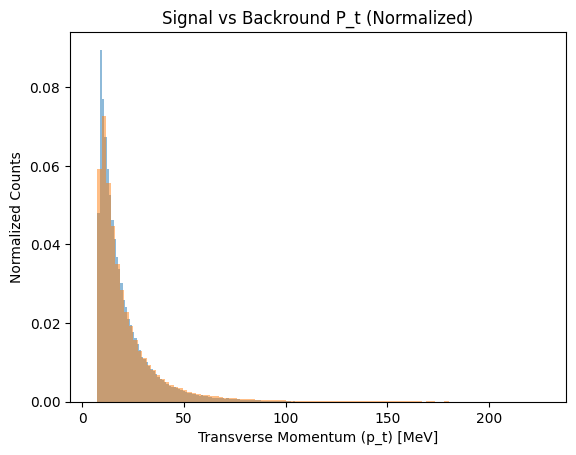

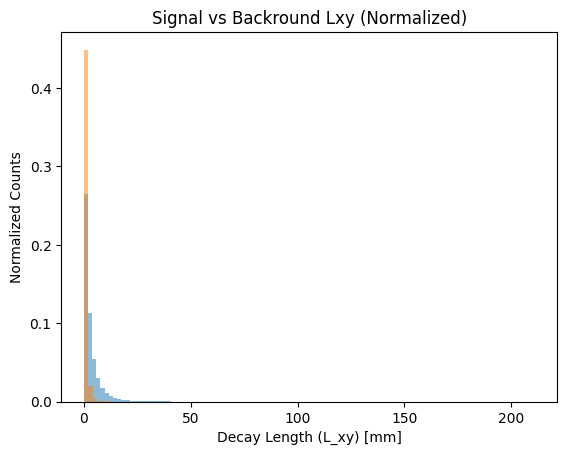

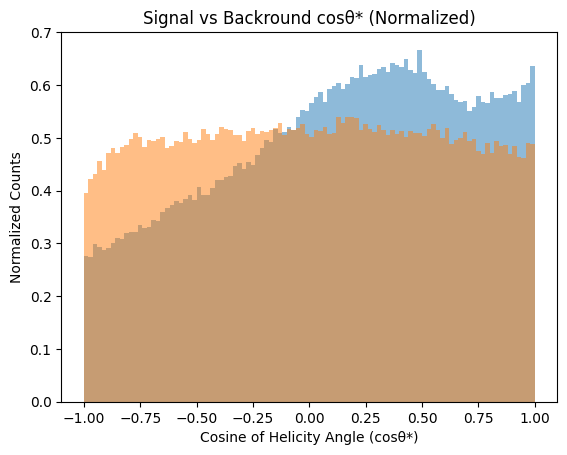

In [322]:
counts, bins, _ = plt.hist(X_train1["DMesons_pt"], bins=100)
counts2, bins2, _ = plt.hist(X_train2["DMesons_pt"], bins=100)
# Normalize the histogram using the formula
density = counts / (sum(counts) * np.diff(bins))
density2 = counts2 / (sum(counts2) * np.diff(bins2))

# Plot the normalized histogram
plt.clf()
plt.bar(bins[:-1], density, width=np.diff(bins), align='edge', alpha=0.5)
plt.bar(bins2[:-1], density2, width=np.diff(bins2), align='edge', alpha=0.5)
plt.title("Signal vs Backround P_t (Normalized)")
plt.xlabel("Transverse Momentum (p_t) [MeV]")
plt.ylabel("Normalized Counts")
plt.show()

counts, bins, _ = plt.hist(X_train1["DMesons_fitOutput__Lxy"], bins=100)
counts2, bins2, _ = plt.hist(X_train2["DMesons_fitOutput__Lxy"], bins=100)
# Normalize the histogram using the formula
density = counts / (sum(counts) * np.diff(bins))
density2 = counts2 / (sum(counts2) * np.diff(bins2))

# Plot the normalized histogram
plt.clf()
plt.bar(bins[:-1], density, width=np.diff(bins), align='edge', alpha=0.5)
plt.bar(bins2[:-1], density2, width=np.diff(bins2), align='edge', alpha=0.5)
plt.title("Signal vs Backround Lxy (Normalized)")
plt.xlabel("Decay Length (L_xy) [mm]")
plt.ylabel("Normalized Counts")
plt.show()

counts, bins, _ = plt.hist(X_train1["DMesons_costhetastar"], bins=100)
counts2, bins2, _ = plt.hist(X_train2["DMesons_costhetastar"], bins=100)
# Normalize the histogram using the formula
density = counts / (sum(counts) * np.diff(bins))
density2 = counts2 / (sum(counts2) * np.diff(bins2))

# Plot the normalized histogram
plt.clf()
plt.bar(bins[:-1], density, width=np.diff(bins), align='edge', alpha=0.5)
plt.bar(bins2[:-1], density2, width=np.diff(bins2), align='edge', alpha=0.5)
plt.title("Signal vs Backround cosθ* (Normalized)")
plt.xlabel("Cosine of Helicity Angle (cosθ*)")
plt.ylabel("Normalized Counts")
plt.show()

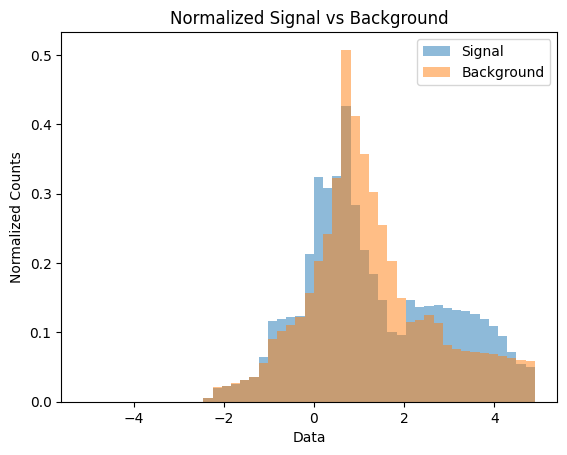

In [323]:
#counts, bins, _ = plt.hist(X_train1, bins=20)
bins = np.linspace(-5, 5, 50)
signal_counts, _ = np.histogram(X_train2, bins=bins, density=True)
background_counts, _ = np.histogram(X_train1, bins=bins, density=True)

# Plot the signal and background histograms on the same plot
plt.bar(bins[:-1], signal_counts, width=np.diff(bins), alpha=0.5, label='Signal')
plt.bar(bins[:-1], background_counts, width=np.diff(bins), alpha=0.5, label='Background')

# Add axis labels and a legend
plt.xlabel('Data')
plt.ylabel('Normalized Counts')
plt.title("Normalized Signal vs Background")
plt.legend()

# Show the plot
plt.show()

In [343]:
wandb.init(
    # set the wandb project where this run will be logged
    project="ATLAS_DNN",

    # track hyperparameters and run metadata with wandb.config
    config={
        "layer_1": 64,
        "activation_1": "relu",
        "dropout_1": 0.5,
        "layer_2": 32,
        "activation_2": "relu",
        "dropout_2": 0.5,
        "output_layer": 1,
        "output_activation": "sigmoid",
        "optimizer": "adam",
        "loss": "binary_crossentropy",
        "metric": "accuracy",
        "epoch": 50,
        "batch_size": 32
    }
)
config = wandb.config

In [344]:
# def get_config(self):
#     return config

class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        config = wandb.config
        self.dense1 = Dense(config.layer_1, activation=config.activation_1)
        self.dropout1 = Dropout(config.dropout_1)
        
        self.dense2 = Dense(config.layer_2, activation = config.activation_2)
        self.dropout2 = Dropout(config.dropout_2)
        
        self.dense3 = Dense(config.output_layer, activation=config.output_activation)
        
    def call(self, x):
        x = self.dense1(x)
        x = self.dropout1(x)
        
        x = self.dense2(x)
        x = self.dropout2(x)
        
        x = self.dense3(x)
        
        return x
    
model = MyModel()
model.build(input_shape=(None, X_train.shape[1]))
model.summary()

def custom_accuracy(y_true, y_pred): 
    
    y_pred_binary = tf.cast(tf.round(y_pred), tf.int32)
    y_true = tf.cast(y_true, tf.int32)
    
    correct_predictions = tf.equal(y_true, y_pred_binary)
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    
    return accuracy

Model: "my_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             multiple                  640       
                                                                 
 dropout_6 (Dropout)         multiple                  0         
                                                                 
 dense_10 (Dense)            multiple                  2080      
                                                                 
 dropout_7 (Dropout)         multiple                  0         
                                                                 
 dense_11 (Dense)            multiple                  33        
                                                                 
Total params: 2,753
Trainable params: 2,753
Non-trainable params: 0
_________________________________________________________________


In [345]:
#Compile
import time

start_time = time.time()

model.compile(optimizer=config.optimizer, loss=config.loss, metrics=[custom_accuracy])

early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')
#Train
history = model.fit(X_train, y_train, epochs=config.epoch, batch_size=config.batch_size, validation_data=(X_test, y_test), callbacks=[early_stop, WandbCallback(), tf.keras.callbacks.History()])

#Evaluate testing set
loss = model.evaluate(X_test, y_test)
print("Loss: {}".format(loss))

end_time = time.time()
runtime = end_time - start_time
print("Training runtime:", runtime, "seconds")

Epoch 1/50
    1/20000 [..............................] - ETA: 5:42:28 - loss: 2.6688 - custom_accuracy: 0.5312WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0015s vs `on_train_batch_end` time: 0.0103s). Check your callbacks.


19989/20000 [============================>.] - ETA: 0s - loss: 0.1329 - custom_accuracy: 0.9487

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230422_014812-ugm4x83y/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230422_014812-ugm4x83y/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230422_014812-ugm4x83y/files/model-best)... Done. 0.1s


20000/20000 [==============================] - 43s 2ms/step - loss: 0.1329 - custom_accuracy: 0.9487 - val_loss: 0.0426 - val_custom_accuracy: 0.9831
Epoch 2/50
19998/20000 [============================>.] - ETA: 0s - loss: 0.0697 - custom_accuracy: 0.9750

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230422_014812-ugm4x83y/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230422_014812-ugm4x83y/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230422_014812-ugm4x83y/files/model-best)... Done. 0.0s


20000/20000 [==============================] - 36s 2ms/step - loss: 0.0697 - custom_accuracy: 0.9750 - val_loss: 0.0354 - val_custom_accuracy: 0.9868
Epoch 3/50
20000/20000 [==============================] - 33s 2ms/step - loss: 0.0644 - custom_accuracy: 0.9772 - val_loss: 0.0408 - val_custom_accuracy: 0.9816
Epoch 4/50
19976/20000 [============================>.] - ETA: 0s - loss: 0.0599 - custom_accuracy: 0.9787

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230422_014812-ugm4x83y/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230422_014812-ugm4x83y/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230422_014812-ugm4x83y/files/model-best)... Done. 0.0s


20000/20000 [==============================] - 34s 2ms/step - loss: 0.0599 - custom_accuracy: 0.9787 - val_loss: 0.0311 - val_custom_accuracy: 0.9888
Epoch 5/50
19967/20000 [============================>.] - ETA: 0s - loss: 0.0580 - custom_accuracy: 0.9795

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230422_014812-ugm4x83y/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230422_014812-ugm4x83y/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230422_014812-ugm4x83y/files/model-best)... Done. 0.0s


20000/20000 [==============================] - 34s 2ms/step - loss: 0.0580 - custom_accuracy: 0.9795 - val_loss: 0.0308 - val_custom_accuracy: 0.9879
Epoch 6/50
19994/20000 [============================>.] - ETA: 0s - loss: 0.0571 - custom_accuracy: 0.9801

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230422_014812-ugm4x83y/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230422_014812-ugm4x83y/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230422_014812-ugm4x83y/files/model-best)... Done. 0.0s


20000/20000 [==============================] - 34s 2ms/step - loss: 0.0570 - custom_accuracy: 0.9801 - val_loss: 0.0308 - val_custom_accuracy: 0.9881
Epoch 7/50
20000/20000 [==============================] - 33s 2ms/step - loss: 0.0545 - custom_accuracy: 0.9808 - val_loss: 0.0340 - val_custom_accuracy: 0.9875
Epoch 8/50
19987/20000 [============================>.] - ETA: 0s - loss: 0.0536 - custom_accuracy: 0.9816

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230422_014812-ugm4x83y/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230422_014812-ugm4x83y/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230422_014812-ugm4x83y/files/model-best)... Done. 0.0s


20000/20000 [==============================] - 33s 2ms/step - loss: 0.0536 - custom_accuracy: 0.9816 - val_loss: 0.0288 - val_custom_accuracy: 0.9888
Epoch 9/50
20000/20000 [==============================] - 33s 2ms/step - loss: 0.0530 - custom_accuracy: 0.9815 - val_loss: 0.0328 - val_custom_accuracy: 0.9882
Epoch 10/50
20000/20000 [==============================] - 33s 2ms/step - loss: 0.0514 - custom_accuracy: 0.9820 - val_loss: 0.0334 - val_custom_accuracy: 0.9887
Epoch 11/50
19977/20000 [============================>.] - ETA: 0s - loss: 0.0507 - custom_accuracy: 0.9818

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230422_014812-ugm4x83y/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230422_014812-ugm4x83y/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230422_014812-ugm4x83y/files/model-best)... Done. 0.0s


20000/20000 [==============================] - 33s 2ms/step - loss: 0.0507 - custom_accuracy: 0.9818 - val_loss: 0.0272 - val_custom_accuracy: 0.9891
Epoch 12/50
20000/20000 [==============================] - 32s 2ms/step - loss: 0.0498 - custom_accuracy: 0.9825 - val_loss: 0.0275 - val_custom_accuracy: 0.9900
Epoch 13/50
19972/20000 [============================>.] - ETA: 0s - loss: 0.0490 - custom_accuracy: 0.9829

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230422_014812-ugm4x83y/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230422_014812-ugm4x83y/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230422_014812-ugm4x83y/files/model-best)... Done. 0.0s


20000/20000 [==============================] - 33s 2ms/step - loss: 0.0490 - custom_accuracy: 0.9829 - val_loss: 0.0263 - val_custom_accuracy: 0.9902
Epoch 14/50
20000/20000 [==============================] - 33s 2ms/step - loss: 0.0481 - custom_accuracy: 0.9832 - val_loss: 0.0268 - val_custom_accuracy: 0.9895
Epoch 15/50
20000/20000 [==============================] - 32s 2ms/step - loss: 0.0479 - custom_accuracy: 0.9833 - val_loss: 0.0290 - val_custom_accuracy: 0.9886
Epoch 16/50
20000/20000 [==============================] - 33s 2ms/step - loss: 0.0477 - custom_accuracy: 0.9833 - val_loss: 0.0311 - val_custom_accuracy: 0.9872
Epoch 16: early stopping
5000/5000 [==============================] - 6s 1ms/step - loss: 0.0311 - custom_accuracy: 0.9872
Loss: [0.031113239005208015, 0.9872312545776367]
Training runtime: 546.8738014698029 seconds


2023-04-22 01:49:08.832374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-04-22 01:49:08.859248: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-04-22 01:49:09.086675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-04-22 01:49:09

In [346]:
wandb.finish()

custom_accuracy,▁▆▇▇▇▇▇█████████
epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_custom_accuracy,▂▅▁▇▆▆▆▇▆▇▇██▇▇▆
val_loss,█▅▇▃▃▃▄▂▄▄▁▂▁▁▂▃
best_epoch,12
best_val_loss,0.02634
custom_accuracy,0.98331
epoch,15
loss,0.04768
val_custom_accuracy,0.98723


------------------------------------------ Finished training, now analyze ------------------------------------------

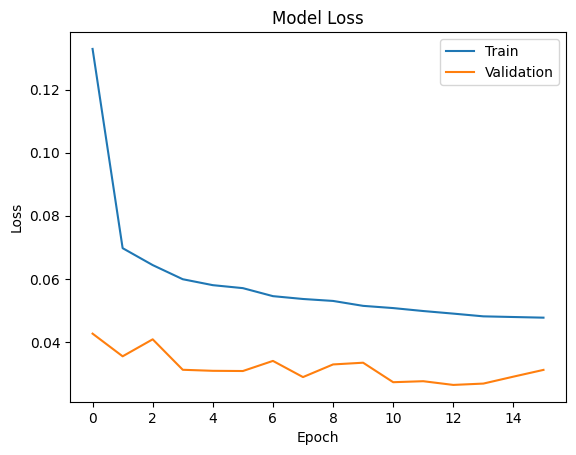

In [347]:
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [348]:
predictions_both = model.predict(X_test)
predictions_both[:10]

5000/5000 [==============================] - 5s 1ms/step


array([[7.1088782e-25],
       [1.0000000e+00],
       [1.0000000e+00],
       [9.9999988e-01],
       [1.6372047e-19],
       [9.9999988e-01],
       [5.7209105e-25],
       [9.9998599e-01],
       [1.3263221e-11],
       [5.5904919e-01]], dtype=float32)

In [349]:
predictions_background = model.predict(X_test1)
predictions_background[:10]

2500/2500 [==============================] - 3s 1ms/step


array([[7.0275242e-08],
       [7.6552309e-22],
       [1.2576581e-16],
       [4.6907729e-03],
       [3.8948545e-32],
       [4.5645117e-28],
       [3.2628909e-02],
       [2.9678710e-30],
       [1.7343564e-11],
       [1.5058629e-31]], dtype=float32)

In [350]:
predictions_signal = model.predict(X_test2)
predictions_signal[:10]

2500/2500 [==============================] - 3s 1ms/step


array([[1.        ],
       [1.        ],
       [0.9999999 ],
       [0.9999999 ],
       [0.9317227 ],
       [0.99985236],
       [0.9987786 ],
       [0.99999905],
       [0.9999999 ],
       [0.9801107 ]], dtype=float32)

In [351]:
predictions_list_both = []
D_count, Lambda_count, unclear = 0, 0, 0

for pred in predictions_both:
    if float(pred) > 0.5:
        predictions_list_both.append(int(1))
        Lambda_count+=1
    elif float(pred) < 0.5:
        predictions_list_both.append(int(0))
        D_count+=1
    else:
        unclear+=1
        
print("$D^+$ Count: {}".format(D_count))
print("$\Lambda_C^+ Count: {}".format(Lambda_count))
print("Unknown Particle Count: {}".format(unclear))
np.shape(predictions_list_both)

$D^+$ Count: 78687
$\Lambda_C^+ Count: 81313
Unknown Particle Count: 0


(160000,)

In [352]:
predictions_list_background = []
D_count, Lambda_count, unclear = 0, 0, 0

for pred in predictions_background:
    if float(pred) > 0.5:
        predictions_list_background.append(int(1))
        Lambda_count+=1
    elif float(pred) < 0.5:
        predictions_list_background.append(int(0))
        D_count+=1
    else:
        unclear+=1
        
print("$D^+$ Count: {}".format(D_count))
print("$\Lambda_C^+ Count: {}".format(Lambda_count))
print("Unknown Particle Count: {}".format(unclear))
np.shape(predictions_list_background)

$D^+$ Count: 78544
$\Lambda_C^+ Count: 1456
Unknown Particle Count: 0


(80000,)

In [353]:
predictions_list_signal = []
D_count, Lambda_count, unclear = 0, 0, 0

for pred in predictions_signal:
    if float(pred) > 0.5:
        predictions_list_signal.append(int(1))
        Lambda_count+=1
    elif float(pred) < 0.5:
        predictions_list_signal.append(int(0))
        D_count+=1
    else:
        unclear+=1
        
print("$D^+$ Count: {}".format(D_count))
print("$\Lambda_C^+ Count: {}".format(Lambda_count))
print("Unknown Particle Count: {}".format(unclear))
np.shape(predictions_list_signal)

$D^+$ Count: 455
$\Lambda_C^+ Count: 79545
Unknown Particle Count: 0


(80000,)

In [354]:
accuracy = np.mean(predictions_list_both == y_test)
print("Accuracy: {:.2%}".format(accuracy))

y_test

Accuracy: 98.72%


212188    0
299036    1
475978    1
588988    1
138859    0
         ..
419306    0
390253    1
490030    1
754179    1
319196    1
Name: DMesons_pdgId, Length: 160000, dtype: int64

In [355]:
accuracy1 = np.mean(predictions_list_background == y_test1)
print("Accuracy: {:.2%}".format(accuracy1))

y_test1

Accuracy: 98.18%


23218     0
20731     0
39555     0
147506    0
314215    0
         ..
54840     0
103       0
339434    0
315677    0
164567    0
Name: DMesons_pdgId, Length: 80000, dtype: int64

In [356]:
accuracy2 = np.mean(predictions_list_signal == y_test2)
print("Accuracy: {:.2%}".format(accuracy2))

y_test2

Accuracy: 99.43%


23218     1
20731     1
39555     1
147506    1
314215    1
         ..
54840     1
103       1
339434    1
315677    1
164567    1
Name: DMesons_pdgId, Length: 80000, dtype: int64

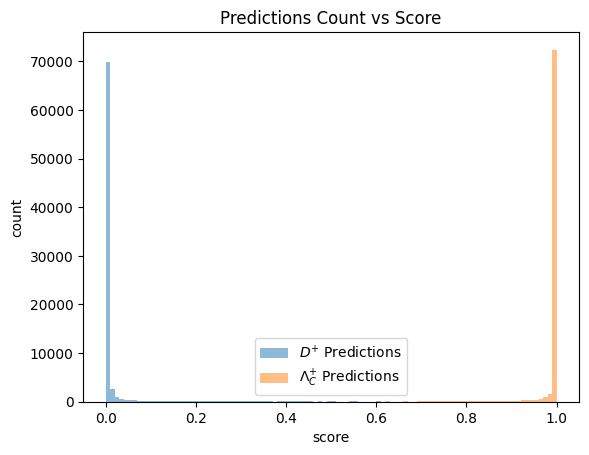

In [357]:
hist = plt.hist(predictions_background, bins = 100, label = "$D^{+}$ Predictions", alpha=0.5)
hist2 = plt.hist(predictions_signal, bins = 100, label = "$\Lambda_C^{+}$ Predictions", alpha=0.5)
plt.xlabel("score")
plt.ylabel("count")
plt.title("Predictions Count vs Score")
plt.legend()
plt.show()

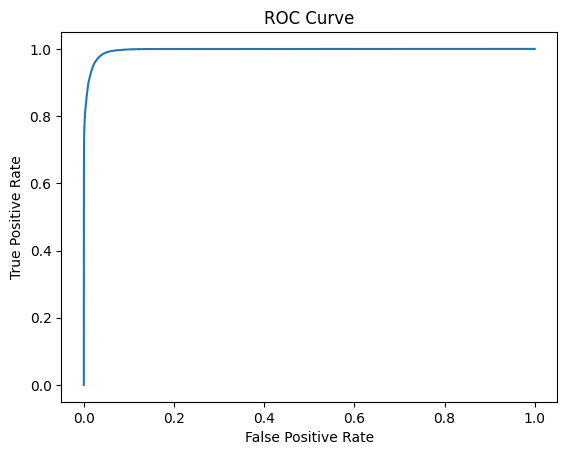

In [358]:
# Get true labels and predicted probabilities
y_true = list(y_test)
y_pred = predictions

# Calculate TPR and FPR for different threshold values
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

# Plot ROC curve
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()